# Menu <a class="anchor" id="menu"></a>
* [1. Exploratory Data Analysis (EDA)](#eda)
* [2. Experimenting various models](#models)
    * [2.0 Preparing the dataset](#models_prepare)
    * [2.1 Establishing a baseline with DummyClassifier](#models_dummy)
    * [2.2 Logistic Regression](#models_linear)
    * [2.3 Decision Tree](#models_decision_tree)
    * [2.4 Random Forest](#models_random_forest)
    * [2.5 XGBoost](#models_xgboost)
* [3. Impoving the models with GreadSearchCV](#models_grid)
    * [3.1 Logistic Regression Grid](#models_linear_grid)
    * [3.2 Decision Tree Grid](#models_decision_tree_grid)
    * [3.3 Random Forest Grid](#models_random_forest_grid)
    * [3.4 XGBoost Grid](#models_xgboost_grid)
* [4. Impoving the models with solutions for Imbalanced datasets](#models_balanced)
    * [4.1 Balanced Logistic Regression Grid](#models_linear_balanced)
    * [4.2 Balanced Decision Tree Grid](#models_decision_tree_balanced)
    * [4.3 Balanced Random Forest Grid](#models_random_forest_balanced)
    * [4.4 Balanced XGBoost Grid](#models_xgboost_balanced)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

from zipfile import ZipFile

#### ---- Let's load the columns selected in the EDA ----

In [2]:
filename = 'data/dtypes_low.csv'

dtypes_df = pd.read_csv(filename, sep=',', index_col=0)

cols_to_keep = dtypes_df.columns
dtypes = dtypes_df.to_dict('records')[0]

#### \<test>

#### \<\test>

In [3]:
zip_file = ZipFile('data/Projet+Mise+en+prod+-+home-credit-default-risk.zip')

In [4]:
data_application_train = pd.read_csv(
    zip_file.open('application_train.csv'),
    #dtype=dtypes, 
    usecols=cols_to_keep,
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

pd.options.display.max_columns = data_application_train.shape[0]
pd.options.display.max_rows = 100

data_application_train.shape

(307511, 52)

#### \<test>

#### \<\test>

## Feature Engigeering

In [5]:
data_clean = data_application_train.copy()

In [6]:
import missingno as msno

# Experimenting various models <a class="anchor" id="models"></a> [⇪](#menu)

## 0. Preparing the dataset <a class="anchor" id="models_prepare"></a> [⇪](#menu)

### Splitting the dataset between `train`, `validation` and `test` sets

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_full = data_clean.copy()
X_full.drop(['TARGET'], axis=1, inplace=True)

Y_full = data_clean['TARGET']

In [9]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.20,
                                                random_state=0,
                                                stratify=Y_full)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(
                                                X_train_full, 
                                                y_train_full, 
                                                test_size=X_test.shape[0], 
                                                random_state=0,
                                                stratify=y_train_full)

In [11]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((184505, 51), (184505,), (61503, 51), (61503,), (61503, 51), (61503,))

### Encoding the qualitative variables

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

In [13]:
oe_targets = [x for x in X_train.select_dtypes(exclude='number').columns if X_train[x].nunique() == 2]
ohe_targets = [x for x in X_train.select_dtypes(exclude='number').columns if X_train[x].nunique() > 2]

In [14]:
def fit_labels(data):
    """ Prepare the encoder for the ordinal columns.
    - Columns with 2 unique values are encoded using an OrdinalEncoder
    - Columns with more than 2 unique values are encoded using a OneHotEncoder
        
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset used as reference for the label encoders
        
    Returns
    -------
    OrdinalEncoder
        the OE instance used to encode columns with 2 unique values
    OneHotEncoder
        the OHE instance used to encode columns with 3+ unique values
    """
    
    oe_targets = []
    ohe_targets = []
    
    for col in data.select_dtypes(exclude='number').columns:
        if data[col].nunique() == 2:
            oe_targets.append(col)
        else:
            ohe_targets.append(col)
        
    # OrdinalEncoder
    oe = OrdinalEncoder()
    oe.fit(data[oe_targets])
    
    # OneHotEncoder
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(data[ohe_targets])
    
    return oe, ohe

def transform_labels(data, oe_model, ohe_mode):
    """ Transform the provided dataset using the provided encoders.
            
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset that needs to be label encoded
        
    Returns
    -------
    DataFrame
        a new dataframe with the encoded labels instead of the non encoded ones
    """
    dt = data.copy()
    
    # OrdinalEncoder
    dt[oe_model.feature_names_in_] = oe_model.transform(dt[oe_model.feature_names_in_])
    
    # OneHotEncoder
    array_hot_encoded = ohe_model.transform(dt[ohe_model.feature_names_in_])
    data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dt.index, columns=ohe_model.get_feature_names_out())
    data_other_cols = dt.drop(columns=ohe_model.feature_names_in_)
    dt = pd.concat([data_hot_encoded, data_other_cols], axis=1)
    
    return dt

#### Fit the encoders

In [15]:
oe_model, ohe_model = fit_labels(X_train)

#### Transform the `training`, `validation` and `testing` sets

In [16]:
X_train = transform_labels(X_train, oe_model, ohe_model)
X_valid = transform_labels(X_valid, oe_model, ohe_model)
X_test = transform_labels(X_test, oe_model, ohe_model)
X_train_full = transform_labels(X_train_full, oe_model, ohe_model)

### Imputations

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [18]:
def fit_imputer(data, columns):
    
    imputer = SimpleImputer(strategy='median')
    #imputer = IterativeImputer(
    #    imputation_order='ascending', 
    #    random_state=0, 
        #min_value=0, 
        #max_value=max_values_imput
    #    n_nearest_features = 10,
    #)
    imputer.fit(data[columns])
    
    return imputer

def impute(data, imputer):
    
    dt = data.copy()
    dt_imput = pd.DataFrame(imputer.transform(dt[imputer.feature_names_in_]), index=dt.index, columns=imputer.feature_names_in_)
    dt[imputer.feature_names_in_] = dt_imput
    print(dt.shape, type(dt))
    
    return dt

In [19]:
imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)

In [20]:
X_train = impute(X_train, imputer_model)
X_valid = impute(X_valid, imputer_model)
X_test = impute(X_test, imputer_model)
X_train_full = impute(X_train_full, imputer_model)

(184505, 153) <class 'pandas.core.frame.DataFrame'>
(61503, 153) <class 'pandas.core.frame.DataFrame'>
(61503, 153) <class 'pandas.core.frame.DataFrame'>


<AxesSubplot:>

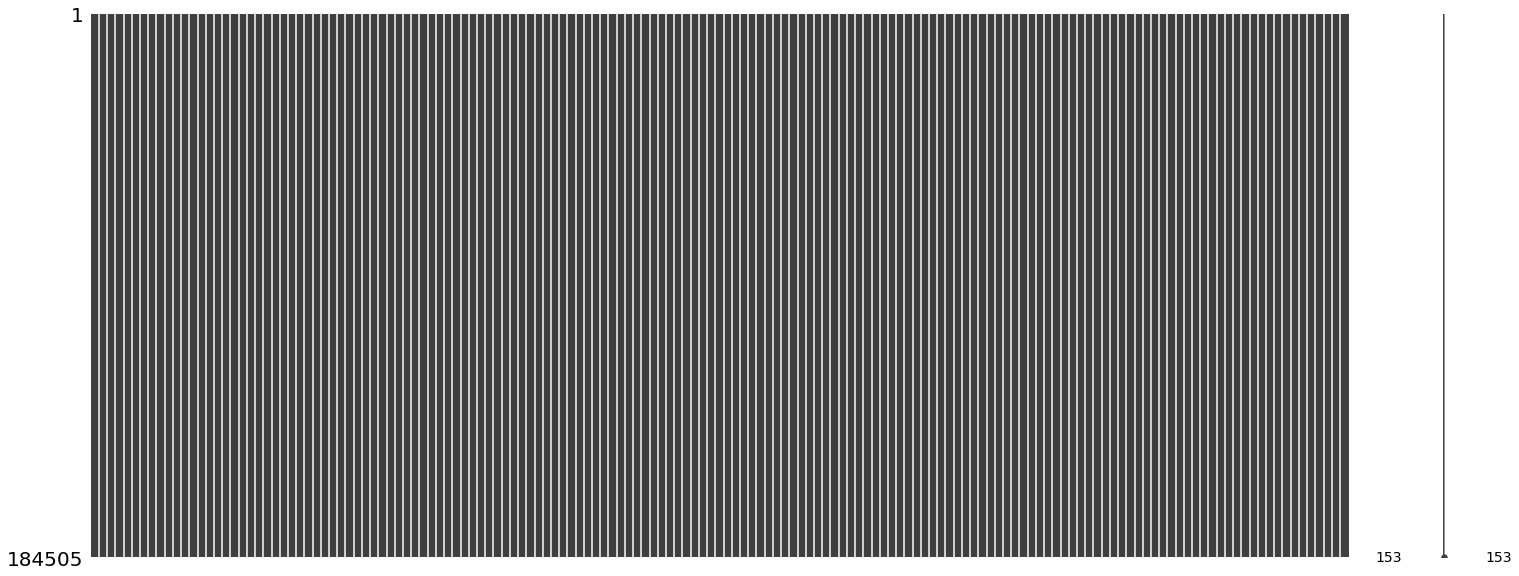

In [21]:
msno.matrix(X_train)

### Normalizing the dataset

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [23]:
def fit_normalizer(data):
    
    #minmax_scaler = MinMaxScaler(feature_range = (0, 1))
    #minmax_scaler.fit(data)
    
    #std_scaler = StandardScaler()
    #std_scaler.fit(data)
    
    #return minmax_scaler, std_scaler
    
    robust_scaler = RobustScaler()
    robust_scaler.fit(data)
    
    return robust_scaler

#def normalize(data, minmax_scaler, std_scaler):
def normalize(data, robust_scaler):
    
    dt = data.copy()
    #dt = pd.DataFrame(minmax_scaler.transform(dt), index=dt.index, columns=dt.columns)
    #dt = pd.DataFrame(std_scaler.transform(dt), index=dt.index, columns=dt.columns)
    dt = pd.DataFrame(robust_scaler.transform(dt), index=dt.index, columns=dt.columns)
    
    return dt

In [24]:
#normalizer_model, standardizer_model = fit_normalizer(X_train)
model_scaler = fit_normalizer(X_train)

In [25]:
#X_train = normalize(X_train, normalizer_model, standardizer_model)
#X_valid = normalize(X_valid, normalizer_model, standardizer_model)
#X_test = normalize(X_test, normalizer_model, standardizer_model)

X_train = normalize(X_train, model_scaler)
X_valid = normalize(X_valid, model_scaler)
X_test = normalize(X_test, model_scaler)
X_train_full = normalize(X_train_full, model_scaler)

### Define some report functions

In [26]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score

In [27]:
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, labels=[0,1], target_names=['Prediction = 0', 'Prediction = 1'], zero_division=0)
    print("--- Classification Report ---\n\n", report)

In [28]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    print("--- Confusion Matrix ---\n")
    plt.show()

In [29]:
def print_rocauc(y_true, y_pred_dict, figsize=[5,5], ax=None):
    
    print(f"--- ROC AUC ---\n")
    auc_scores = {}
    last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt

    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        alpha_v = 1 if i == last_index-1 else 0.5
        
        roc_score = roc_auc_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        
        ax.plot(fpr, tpr, label=f"{model_name} ({roc_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = roc_score
            
    ax.plot([0, 1], [0, 1], label='Random (0.5)', linestyle='--', color='red', alpha=0.5)
    plt.xlabel('FPR (Positive label: 1)')
    plt.ylabel('TPR (Positive label: 1)')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    return auc_scores

In [30]:
scores = pd.DataFrame(columns=['Method', 'ROC AUC', 'F1 score', 'Accuracy', 'Precision', 'Recall', 'TP', 'TN', 'FP', 'FN', 'Training time', 'Inference time'])
y_preds = {}
scores_path = 'data/scores.csv'
scores.to_csv(scores_path, index=False)

import time

def get_scores(method_name, model, X_ref=None, y_ref=None, threshold=None, training_time=None, inference_time=None, register=False, simple=False, show_classification=True, show_confusion=True, show_roccurves=True):
    
    if X_ref==None:
        X_ref = X_test
        
    if y_ref==None:
        y_ref = y_test
    
    y_pred, y_pred_proba, inference_time = predict(model, X_ref, threshold)
    
    rocauc_value = roc_auc_score(y_ref, y_pred_proba)
    f1_value = f1_score(y_ref, y_pred)
    accuracy_value = accuracy_score(y_ref, y_pred)
    precision_value = precision_score(y_ref, y_pred, zero_division=0)
    recall_value = recall_score(y_ref, y_pred)
    
    cm = confusion_matrix(y_ref, y_pred, labels=[0,1])
    TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    
    # Register score and replace if it already exists
    if register:
        idx = np.where(scores.Method == method_name)[0]        
        idx = idx[0] if idx.size > 0 else len(scores.index)
        scores.loc[idx] = [method_name, rocauc_value, f1_value, accuracy_value, precision_value, recall_value, TP, TN, FP, FN, training_time, inference_time]
        
        scores.to_csv(scores_path, index=False)
    
    # Basic report
    print(f"--- {method_name} ---\n\nROC AUC:{rocauc_value}\nF1-score:{f1_value}\nRecall:{recall_value}\n")
    
    if simple:
        return
    
    # Classification report
    if show_classification:
        print_classification_report(y_ref, y_pred)
    
    # Confusion Matrix
    if show_confusion:
        print_confusion_matrix(y_ref, y_pred)
    
    # ROC AUC curves
    if show_roccurves:
        y_preds[method_name] = y_pred_proba
        print_rocauc(y_ref, y_preds)

In [31]:
def get_labels_from_threshold(y_proba, threshold):
    return (y_proba >= threshold).astype('int')

def find_best_threshold(model, X_valid, y_valid, eval_function ):

    best_threshold = 0.0
    best_score = 0.0
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    
    for threshold in np.arange(0, 1, 0.001):
        
        y_pred_threshold = get_labels_from_threshold(y_pred_proba, threshold)
        
        score = eval_function(y_valid, y_pred_threshold)
        if score >= best_threshold:
            best_threshold = threshold
            best_score = score
        
    return best_score, best_threshold

In [32]:
def predict(model, X_ref, threshold=None):
    t0 = time.perf_counter()
    
    y_pred_proba = model.predict_proba(X_test)[:,1]
    if threshold:
        y_pred = get_labels_from_threshold(y_pred_proba, threshold)
    else:
        y_pred = model.predict(X_test)
    
    tt = time.perf_counter() - t0
    return y_pred, y_pred_proba, tt

## 1. Establishing baseline with Dummy Classifier <a class="anchor" id="models_dummy"></a> [⇪](#menu)

In [33]:
from sklearn.dummy import DummyClassifier

In [34]:
clf_dummy = DummyClassifier(strategy='stratified', random_state=0)

In [35]:
t0 = time.perf_counter()

clf_dummy.fit(X_train, y_train)

tt = time.perf_counter() - t0

--- Dummy ---

ROC AUC:0.5003972944860015
F1-score:0.0810126582278481
Recall:0.08056394763343404

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.92      0.92     56538
Prediction = 1       0.08      0.08      0.08      4965

      accuracy                           0.85     61503
     macro avg       0.50      0.50      0.50     61503
  weighted avg       0.85      0.85      0.85     61503

--- Confusion Matrix ---



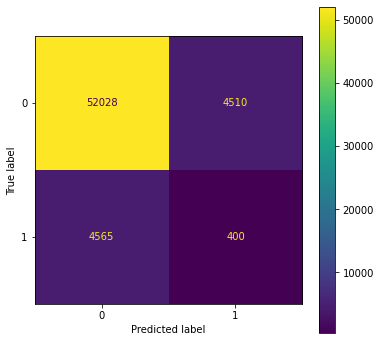

--- ROC AUC ---



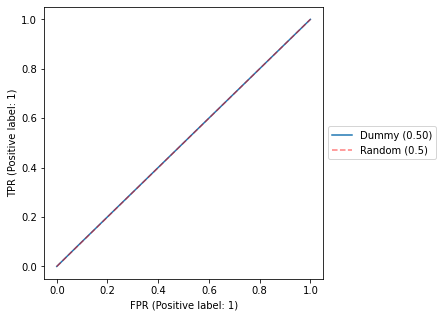

In [36]:
get_scores("Dummy", clf_dummy, training_time=tt, register=True)

> - The **recall** means "how many of this class you find over the whole number of element of this class"
> - The **precision** will be "how many are correctly classified among that class"
> - The **f1-score** is the harmonic mean between precision & recall
> - The **support** is the number of occurence of the given class in your dataset


## 2. Logistic Regression <a class="anchor" id="models_linear"></a> [⇪](#menu)

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
clf_log = LogisticRegression(C=0.1, random_state=0)

In [39]:
t0 = time.perf_counter()

clf_log.fit(X_train, y_train)

tt = time.perf_counter() - t0

/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Basic Logistic Regression ---

ROC AUC:0.743976468766811
F1-score:0.014691284494738934
Recall:0.0074521651560926485

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96     56538
Prediction = 1       0.51      0.01      0.01      4965

      accuracy                           0.92     61503
     macro avg       0.72      0.50      0.49     61503
  weighted avg       0.89      0.92      0.88     61503

--- Confusion Matrix ---



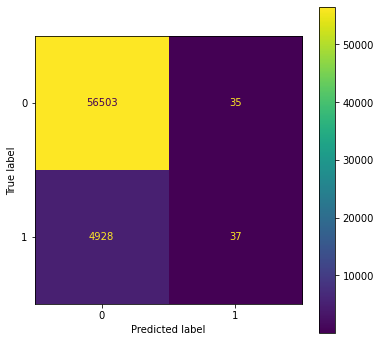

--- ROC AUC ---



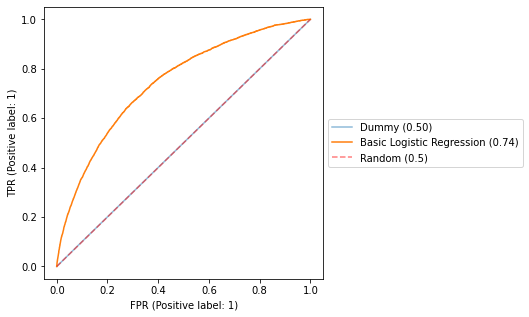

In [40]:
get_scores("Basic Logistic Regression", clf_log, training_time=tt, register=True)

#### Let's find the best threshold

In [41]:
f1_value, best_threshold = find_best_threshold(clf_log, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.22680931403398363) for this model is reached with a threshold of 0.227


--- Basic RegLog with 0.227 threshold ---

ROC AUC:0.743976468766811
F1-score:0.23145699534063718
Recall:0.1850956696878147

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.96      0.95     56538
Prediction = 1       0.31      0.19      0.23      4965

      accuracy                           0.90     61503
     macro avg       0.62      0.57      0.59     61503
  weighted avg       0.88      0.90      0.89     61503

--- Confusion Matrix ---



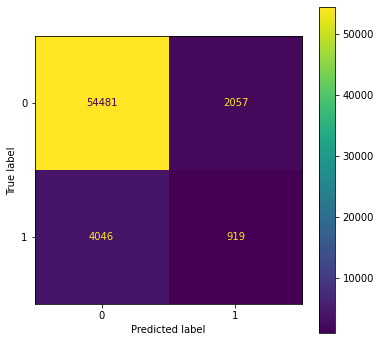

In [42]:
get_scores(f"Basic RegLog with {best_threshold} threshold", clf_log, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 3. Decision Tree <a class="anchor" id="models_decision_tree"></a> [⇪](#menu)

In [43]:
from sklearn.tree import DecisionTreeClassifier

In [44]:
clf_dt = DecisionTreeClassifier(random_state=0)

In [45]:
t0 = time.perf_counter()

clf_dt.fit(X_train, y_train)

tt = time.perf_counter() - t0

--- Basic Decision Tree ---

ROC AUC:0.5379417356281191
F1-score:0.15111532985287138
Recall:0.16032225579053375

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.92      0.92     56538
Prediction = 1       0.14      0.16      0.15      4965

      accuracy                           0.85     61503
     macro avg       0.53      0.54      0.54     61503
  weighted avg       0.86      0.85      0.86     61503

--- Confusion Matrix ---



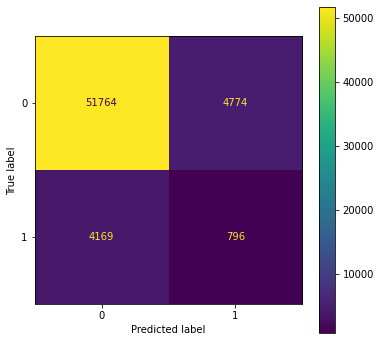

--- ROC AUC ---



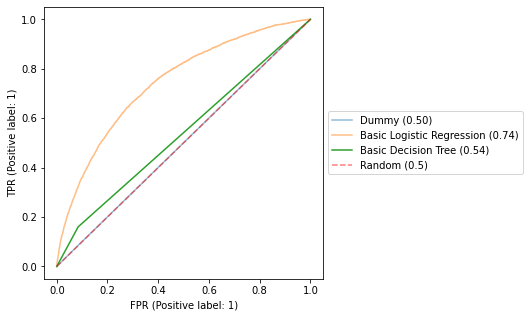

In [46]:
get_scores("Basic Decision Tree", clf_dt, training_time=tt, register=True)

#### Let's find the best threshold

In [47]:
f1_value, best_threshold = find_best_threshold(clf_dt, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.15152378239817718) for this model is reached with a threshold of 0.152


--- Basic Decision Tree with 0.152 threshold ---

ROC AUC:0.5379417356281191
F1-score:0.15111532985287138
Recall:0.16032225579053375

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.92      0.92     56538
Prediction = 1       0.14      0.16      0.15      4965

      accuracy                           0.85     61503
     macro avg       0.53      0.54      0.54     61503
  weighted avg       0.86      0.85      0.86     61503

--- Confusion Matrix ---



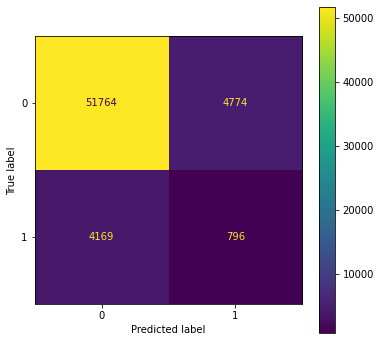

In [48]:
get_scores(f"Basic Decision Tree with {best_threshold} threshold", clf_dt, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 4. Random Forest <a class="anchor" id="models_random_forest"></a> [⇪](#menu)

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
clf_rf = RandomForestClassifier(random_state=0, n_jobs=-1, min_samples_split=100)

In [51]:
t0 = time.perf_counter()

clf_rf.fit(X_train, y_train)

tt = time.perf_counter() - t0

--- Basic Random Forest ---

ROC AUC:0.7385009581200492
F1-score:0.00040273862263391055
Recall:0.0002014098690835851

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96     56538
Prediction = 1       1.00      0.00      0.00      4965

      accuracy                           0.92     61503
     macro avg       0.96      0.50      0.48     61503
  weighted avg       0.93      0.92      0.88     61503

--- Confusion Matrix ---



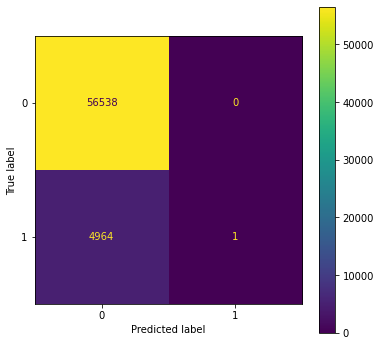

--- ROC AUC ---



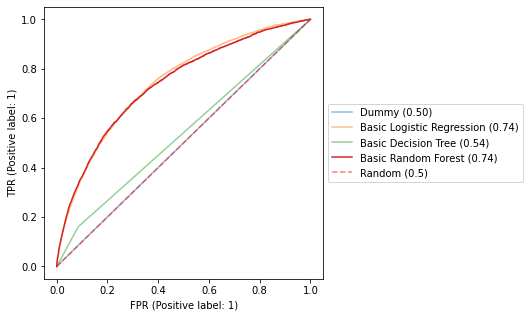

In [52]:
get_scores("Basic Random Forest", clf_rf, training_time=tt, register=True)

#### Let's find the best threshold

In [53]:
f1_value, best_threshold = find_best_threshold(clf_rf, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

KeyboardInterrupt: 

In [ ]:
get_scores(f"Basic Random Forest with {best_threshold} threshold", clf_rf, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 5. XGBoost Classifier <a class="anchor" id="models_xgboost"></a> [⇪](#menu)

In [ ]:
from xgboost import XGBClassifier

In [ ]:
clf_xgb = XGBClassifier(
    # max_depth=6,
    # min_child_weight=1,
    objective='binary:logistic', # classification
    eval_metric='auc', # classification
    nthread=-1,
    seed=0,
    verbosity=1
)

In [ ]:
t0 = time.perf_counter()

clf_xgb.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
get_scores("Basic XGBoost", clf_xgb, training_time=tt, register=True)

#### Let's find the best threshold

In [ ]:
f1_value, best_threshold = find_best_threshold(clf_xgb, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
get_scores(f"Basic XGBoost with {best_threshold} threshold", clf_xgb, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 6. Review scores <a class="anchor" id="models_scores"></a> [⇪](#menu)

In [ ]:
scores

In [ ]:
scores[['Method', 'ROC AUC', 'F1 score', 'Recall']]

# Improving the models with GridSearchCV <a class="anchor" id="models_grid"></a> [⇪](#menu)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold

In [ ]:
num_samples = 10000
X_train_full = X_train_full[:num_samples]
y_train_full = y_train_full[:num_samples]

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

## 1. Logistic Regression Grid<a class="anchor" id="models_linear_grid"></a> [⇪](#menu)

In [ ]:
param_grid = [
    {
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'solver' : ['saga'],
        'penalty' : ['l1', 'l2', 'elasticnet'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]


In [ ]:
clf_log_model = LogisticRegression(max_iter=1000, random_state=0)
clf_log_grid = GridSearchCV(clf_log_model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,

In [ ]:
t0 = time.perf_counter()

#clf_log_grid.fit(X_train_full, y_train_full)
clf_log_grid.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
clf_log_grid.best_params_

In [ ]:
get_scores("Grid LogReg", clf_log_grid, training_time=tt, register=False, simple=True)

#### Let's find the best threshold

In [ ]:
f1_value, best_threshold = find_best_threshold(clf_log_grid, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

#### We train a new model using the best parameters

In [ ]:
clf_log2 = LogisticRegression( **clf_log_grid.best_params_, random_state=0, max_iter=1000 )

In [ ]:
t0 = time.perf_counter()

#clf_log2.fit(X_train_full, y_train_full)
clf_log2.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
get_scores("Grid LogReg", clf_log2, training_time=tt, register=True)

#### Let's use the best threshold

In [ ]:
get_scores(f"Grid LogReg with {best_threshold} threshold", clf_log2, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 2. Decision Tree Grid <a class="anchor" id="models_decision_tree_grid"></a> [⇪](#menu)

In [ ]:
param_grid = {
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    #'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
    'criterion' :['gini', 'entropy']
}

In [ ]:
clf_dt_model = DecisionTreeClassifier(random_state=0)
clf_dt_grid = GridSearchCV(clf_dt_model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,

In [ ]:
t0 = time.perf_counter()

#clf_dt_grid.fit(X_train_full, y_train_full)
clf_dt_grid.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
clf_dt_grid.best_params_

In [ ]:
get_scores("Grid Decision Tree", clf_dt_grid, training_time=tt, register=False, simple=True)

#### Let's find the best threshold

In [ ]:
f1_value, best_threshold = find_best_threshold(clf_dt_grid, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

#### We train a new model using the best parameters

In [ ]:
clf_dt2 = DecisionTreeClassifier( **clf_dt_grid.best_params_, random_state=0 )

In [ ]:
t0 = time.perf_counter()

#clf_dt2.fit(X_train_full, y_train_full)
clf_dt2.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
get_scores("Grid Decision Tree", clf_dt2, training_time=tt, register=True)

#### Let's use the best threshold

In [ ]:
get_scores(f"Grid Decision Tree with {best_threshold} threshold", clf_dt2, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 3. Random Forest Grid <a class="anchor" id="models_random_forest_grid"></a> [⇪](#menu)

In [ ]:
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    'n_estimators' :[64, 100, 128, 256, 528]
}

In [ ]:
clf_rf_model = RandomForestClassifier(random_state=0)
clf_rf_grid = GridSearchCV(clf_rf_model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,

In [ ]:
t0 = time.perf_counter()

#clf_rf_grid.fit(X_train_full, y_train_full)
clf_rf_grid.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
clf_rf_grid.best_params_

In [ ]:
get_scores("Grid Random Forest", clf_rf_grid, training_time=tt, register=False, simple=True)

#### Let's find the best threshold

In [ ]:
f1_value, best_threshold = find_best_threshold(clf_rf_grid, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

#### We train a new model using the best parameters

In [ ]:
clf_rf2 = RandomForestClassifier( **clf_rf_grid.best_params_, random_state=0 )

In [ ]:
t0 = time.perf_counter()

#clf_rf2.fit(X_train_full, y_train_full)
clf_rf2.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
get_scores("Grid Random Forest", clf_rf2, training_time=tt, register=True)

#### Let's use the best threshold

In [ ]:
get_scores(f"Grid Random Forest with {best_threshold} threshold", clf_rf2, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 4. XGBoost Classifier Grid<a class="anchor" id="models_xgboost_grid"></a> [⇪](#menu)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [ ]:
clf_xgb_model = XGBClassifier(
    # max_depth=6,
    # min_child_weight=1,
    objective='binary:logistic', # classification
    eval_metric='auc', # classification
    nthread=-1,
    seed=0,
    verbosity=1
)
clf_xgb_grid = RandomizedSearchCV(clf_xgb_model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,

In [ ]:
t0 = time.perf_counter()

#clf_xgb_grid.fit(X_train_full, y_train_full)
clf_xgb_grid.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
clf_xgb_grid.best_params_

In [ ]:
get_scores("Grid GXBoost", clf_xgb_grid, training_time=tt, register=False, simple=True)

#### Let's find the best threshold

In [ ]:
f1_value, best_threshold = find_best_threshold(clf_xgb_grid, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

#### We train a new model using the best parameters

In [ ]:
clf_xgb2 = XGBClassifier(
    # max_depth=6,
    # min_child_weight=1,
    objective='binary:logistic', # classification
    eval_metric='auc', # classification
    nthread=-1,
    seed=0,
    verbosity=1,
    **clf_xgb_grid.best_params_, 
)

In [ ]:
t0 = time.perf_counter()

#clf_xgb2.fit(X_train_full, y_train_full)
clf_xgb2.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
get_scores("Grid XGBoost", clf_xgb2, training_time=tt, register=True)

#### Let's use the best threshold

In [ ]:
get_scores(f"Grid XGBoost with {best_threshold} threshold", clf_xgb2, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 5. Review scores <a class="anchor" id="models_grid_scores"></a> [⇪](#menu)

In [ ]:
scores

In [ ]:
scores[['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values('Recall', ascending=False)

# Impoving the models with solutions for Imbalanced datasets <a class="anchor" id="models_balanced"></a> [⇪](#menu)

## 1. Balanced Logistic Regression Grid<a class="anchor" id="models_linear_balanced"></a> [⇪](#menu)

In [ ]:
param_grid = [
    {
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'solver' : ['saga'],
        'penalty' : ['l1', 'l2', 'elasticnet'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [ ]:
clf_log_model_imb = LogisticRegression(max_iter=1000, random_state=0, class_weight='balanced')
clf_log_imb = GridSearchCV(clf_log_model_imb, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,

In [ ]:
t0 = time.perf_counter()

#clf_log_imb.fit(X_train_full, y_train_full)
clf_log_imb.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
clf_log_imb.best_params_

In [ ]:
get_scores("Balanced LogReg", clf_log_imb, training_time=tt, register=False, simple=True)

#### Let's find the best threshold

In [ ]:
f1_value, best_threshold = find_best_threshold(clf_log_imb, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

#### We train a new model using the best parameters

In [ ]:
clf_log_imb2 = LogisticRegression( **clf_log_imb.best_params_, max_iter=1000, random_state=0, class_weight='balanced')

In [ ]:
t0 = time.perf_counter()

#clf_log_imb2.fit(X_train_full, y_train_full)
clf_log_imb2.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
get_scores("Balanced LogReg", clf_log_imb2, training_time=tt, register=True)

#### Let's use the best threshold

In [ ]:
get_scores(f"Balanced LogReg with {best_threshold} threshold", clf_log_imb2, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 2. Balanced Decision Tree Grid <a class="anchor" id="models_decision_tree_balanced"></a> [⇪](#menu)

In [ ]:
param_grid = {
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    #'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
    'criterion' :['gini', 'entropy']
}

In [ ]:
clf_dt_model_imb = DecisionTreeClassifier(random_state=0, class_weight='balanced')
clf_dt_imb = GridSearchCV(clf_dt_model_imb, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,

In [ ]:
t0 = time.perf_counter()

#clf_dt_imb.fit(X_train_full, y_train_full)
clf_dt_imb.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
clf_dt_imb.best_params_

In [ ]:
get_scores("Balanced Decision Tree", clf_dt_imb, training_time=tt, register=False, simple=True)

#### Let's find the best threshold

In [ ]:
f1_value, best_threshold = find_best_threshold(clf_dt_imb, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

#### We train a new model using the best parameters

In [ ]:
clf_dt_imb2 = DecisionTreeClassifier( **clf_dt_imb.best_params_, random_state=0, class_weight='balanced' )

In [ ]:
t0 = time.perf_counter()

#clf_dt_imb2.fit(X_train_full, y_train_full)
clf_dt_imb2.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
get_scores("Balanced Decision Tree", clf_dt_imb2, training_time=tt, register=True)

#### Let's use the best threshold

In [ ]:
get_scores(f"Balanced Decision Tree with {best_threshold} threshold", clf_dt_imb2, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 3. Balanced Random Forest Grid <a class="anchor" id="models_random_forest_balanced"></a> [⇪](#menu)

In [ ]:
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    'n_estimators' :[64, 100, 128, 256, 528]
}

In [ ]:
clf_rf_model_imb = RandomForestClassifier(random_state=0, class_weight='balanced')
clf_rf_imb = GridSearchCV(clf_rf_model_imb, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,

In [ ]:
t0 = time.perf_counter()

#clf_rf_imb.fit(X_train_full, y_train_full)
clf_rf_imb.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
clf_rf_imb.best_params_

In [ ]:
get_scores("Balanced Random Forest", clf_rf_imb, training_time=tt, register=False, simple=True)

#### Let's find the best threshold

In [ ]:
f1_value, best_threshold = find_best_threshold(clf_rf_imb, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

#### We train a new model using the best parameters

In [ ]:
clf_rf_imb2 = RandomForestClassifier( **clf_rf_imb.best_params_, random_state=0, class_weight='balanced')

In [ ]:
t0 = time.perf_counter()

#clf_rf_imb2.fit(X_train_full, y_train_full)
clf_rf_imb2.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
get_scores("Balanced Random Forest", clf_rf_imb2, training_time=tt, register=True)

#### Let's use the best threshold

In [ ]:
get_scores(f"Balanced Random Forest with {best_threshold} threshold", clf_rf_imb2, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 4. Balanced XGBoost Classifier Grid<a class="anchor" id="models_xgboost_balanced"></a> [⇪](#menu)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [ ]:
from collections import Counter

In [ ]:
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]
scale_weigth

In [ ]:
clf_xgb_model_imb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    nthread=8,
    seed=0,
    verbosity=1,
    scale_pos_weight=scale_weigth
)
clf_xgb_imb = RandomizedSearchCV(clf_xgb_model_imb, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,

In [ ]:
t0 = time.perf_counter()

#clf_xgb_imb.fit(X_train_full, y_train_full)
clf_xgb_imb.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
clf_xgb_imb.best_params_

In [ ]:
get_scores("Balanced XGBoost", clf_xgb_imb, training_time=tt, register=False, simple=True)

#### Let's find the best threshold

In [ ]:
f1_value, best_threshold = find_best_threshold(clf_xgb_imb, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

#### We train a new model using the best parameters

In [ ]:
clf_xgb_imb2 = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    nthread=-1,
    seed=0,
    verbosity=1,
    **clf_xgb_imb.best_params_, 
    random_state=0,
    scale_pos_weight=scale_weigth
)

In [ ]:
t0 = time.perf_counter()

#clf_xgb_imb2.fit(X_train_full, y_train_full)
clf_xgb_imb2.fit(X_train, y_train)

tt = time.perf_counter() - t0

In [ ]:
get_scores("Balanced XGBoost", clf_xgb_imb2, training_time=tt, register=True)

#### Let's use the best threshold

In [ ]:
get_scores(f"Balanced XGBoost with {best_threshold} threshold", clf_xgb_imb2, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 5. Review scores <a class="anchor" id="models_balanced_scores"></a> [⇪](#menu)

In [ ]:
scores

In [ ]:
scores[['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values('ROC AUC', ascending=False)

# Custom metric <a class="anchor" id="custom_metric"></a> [⇪](#menu)

## 1. The problem <a class="anchor" id="custom_metric_problem"></a> [⇪](#menu)

>#### Let's interpret the four correlation matrix values in regards to this project:
> - `(TP) True Positive` : the client is predicted as NOT OK and it really is NOT OK. *(we **save** money)*
> - `(TN) True Negative` : the client is predicted as OK and it really is OK. *(we **earn** money)*
> - `(FP) False Positive` : the client is predicted as OK but it is in fact NOT OK. *(we **miss** money)*
> - `(FN) False Negative` : the client is predicted as NOT OK but it is in fact OK. *(we **lose** money)*
>
>#### So the goals in order of importance are:
> 1. minimize the `(FN) False Negative` to **avoid losing money**.
> 2. maximize the `(TN) True Negative` to **earn money**.
> 3. maximize the `(TP) True Positive` to save money.
> 4. minimize the `(FP) False Positive` to avoid missing money.

>#### Currently we are using the F1-measure and the ROC-AUC score.
>
> - The `F1-Measure` **balance the weight** on PRECISION and RECALL.
> - The `ROC AUC score`  summarize the **trade-off** between the true positive rate (RECALL) and false positive rate (ANTI-SPECIFICITY).
>

> RECALL = $\frac{TP}{TP + FN}$
> - High RECALL favors TP over FN
> - Low RECALL favors FN over TP

> PRECISION = $\frac{TP}{TP + FP}$
> - High PRECISION favors TP over FP
> - Low PRECISION favors FP over TP

> ANTI-SPECIFICITY = 1 - SPECIFICITY = 1 - $\frac{TN}{TN + FS}$ = $\frac{FP}{FP + TN}$
> - High ANTI-SPECIFICITY favors FP over TN
> - Low ANTI-SPECIFICITY favors TN over FP

## 2. F-measure <a class="anchor" id="custom_metric_solution"></a> [⇪](#menu)

> * `F0.5-Measure`: **More weight on precision**, less weight on recall.
> * `F1-Measure`  : **Balance the weight** on precision and recall.
> * `F2-Measure`  : **More weight on recall**, less weight on precision.

>#### And luckily, there exists a [Fbeta-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) function in sklearn, which can be used to reproduce those F-measure and any in between measure... So we can in fact decide how much weight we want to give to RECALL.

>#### We want to maximize this `Fbeta-score` with beta > 1.0 !

In [ ]:
from sklearn.metrics import fbeta_score
fb_score = fbeta_score(y_test, y_pred_log, beta=2.0)
fb_score

# Feature Engineering

In [ ]:
data_application_full = pd.read_csv(
    zip_file.open('application_train.csv'),
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

data_application_full.shape

### What fraction of the price of the goods for which the loan is given, represent the credit amount?

In [ ]:
data_application_full['FRAC_GOODS_PRICE'] = data_application_full.AMT_CREDIT / data_application_full.AMT_GOODS_PRICE

In [ ]:
data_application_full[['AMT_CREDIT','AMT_GOODS_PRICE','FRAC_GOODS_PRICE']].head()

### How old was the client when it started his current employement position?

In [ ]:
data_application_full['AGE_EMPLOYEMENT'] = (data_application_full.DAYS_BIRTH - data_application_full.DAYS_EMPLOYED) / -365

In [ ]:
data_application_full[['DAYS_BIRTH','DAYS_EMPLOYED','AGE_EMPLOYEMENT']].head()

### What fraction of the total incomes per member of the family?

In [ ]:
data_application_full['INCOME_PER_FAM_MEMBER'] = data_application_full.AMT_INCOME_TOTAL / data_application_full.CNT_FAM_MEMBERS

In [ ]:
data_application_full[['AMT_INCOME_TOTAL','CNT_FAM_MEMBERS','INCOME_PER_FAM_MEMBER']].head()

### How many requests overall have been made to the credit bureau?

In [ ]:
data_application_full['AMT_REQ_CREDIT_BUREAU_TOTAL'] =  data_application_full.AMT_REQ_CREDIT_BUREAU_HOUR +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_DAY +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_WEEK +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_MON +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_QRT +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_YEAR

In [ ]:
data_application_full[['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR','AMT_REQ_CREDIT_BUREAU_TOTAL']].head()

In [ ]:
data_application_train2 = data_application_train.copy()

In [ ]:
data_application_train2['FRAC_GOODS_PRICE'] = data_application_full['FRAC_GOODS_PRICE']
data_application_train2['AGE_EMPLOYEMENT'] = data_application_full['AGE_EMPLOYEMENT']
data_application_train2['INCOME_PER_FAM_MEMBER'] = data_application_full['INCOME_PER_FAM_MEMBER']
data_application_train2['AMT_REQ_CREDIT_BUREAU_TOTAL'] = data_application_full['AMT_REQ_CREDIT_BUREAU_TOTAL']

In [ ]:
correlations = data_application_train2.corr(method='pearson')

#### ---- Let's check for the top correlations with the `TARGET` variable ----

In [ ]:
view_size = 100
threshold = 0.0
corr_target = correlations.TARGET.sort_values(ascending=False)
print(f"{f'TOP POSITIVES > {threshold}'.rjust(40)}          {f'TOP NEGATIVES < -{threshold}'.rjust(40)}\n{'-'*100}")
for i, row in enumerate(zip(
    corr_target.head(view_size).index, corr_target.head(view_size), 
    reversed(corr_target.tail(view_size).index), reversed(corr_target.tail(view_size)))):
    
    print(f"{row[0].rjust(40)} : {row[1]:6.4f} {row[2].rjust(40)} : {row[3]:6.4f}")
    if((row[1] < threshold and row[3] > -threshold) or (i>=len(corr_target)//2)):
        break

In [ ]:
correlations = data_application_train.corr(method='pearson')

#### ---- Let's check for the top correlations with the `TARGET` variable ----

In [ ]:
view_size = 100
threshold = 0.0
corr_target = correlations.TARGET.sort_values(ascending=False)
print(f"{f'TOP POSITIVES > {threshold}'.rjust(40)}          {f'TOP NEGATIVES < -{threshold}'.rjust(40)}\n{'-'*100}")
for i, row in enumerate(zip(
    corr_target.head(view_size).index, corr_target.head(view_size), 
    reversed(corr_target.tail(view_size).index), reversed(corr_target.tail(view_size)))):
    
    print(f"{row[0].rjust(40)} : {row[1]:6.4f} {row[2].rjust(40)} : {row[3]:6.4f}")
    if((row[1] < threshold and row[3] > -threshold) or (i>=len(corr_target)//2)):
        break

In [ ]:
import FreeMobileSMS as sms
sms.send()